In [28]:
#Compare multiple algorithms on the same dataset.
#Check metrics (RMSE, MAE, R², etc.).
#Decide which algorithm performs best before writing the final train.py.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Linear Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, RANSACRegressor

# Tree-based
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor

# Others
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

pd.set_option("display.max_columns", None)

In [29]:
# Load cleaned data
df = pd.read_csv("../data/clean/train_clean.csv")


In [30]:

# Define target and features
TARGET = "SalePrice"
X = df.drop(columns=[TARGET])
y = df[TARGET]

In [31]:
#  Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [32]:
#  Identify categorical and numerical features
num_cols = X.select_dtypes(exclude="object").columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()

# Ordinal features
ordinal_cols = ["ExterQual", "KitchenQual", "HeatingQC", "BsmtQual", "GarageQual"]
ord_map = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0}


In [33]:
# Preprocessing pipelines

# Numeric pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Ordinal pipeline
ord_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OrdinalEncoder(categories=[list(ord_map.keys())]*len(ordinal_cols)))
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(handle_unknown="ignore" ,sparse_output=False))
])

# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("ord", ord_pipeline, ordinal_cols),
        ("cat", cat_pipeline, [c for c in cat_cols if c not in ordinal_cols])
    ],
    remainder="drop"
)

In [34]:
# Define models
models = {
    # Linear Models
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "RANSACRegressor": RANSACRegressor(),

    # Tree-Based
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),

    # Others
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,100), max_iter=500, random_state=42),

    # Ensembles
    "Bagging": BaggingRegressor(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "Voting": VotingRegressor([
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=50, random_state=42))
    ])
}


In [35]:
#  Evaluate all models
results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    try:
        # Fit and predict
        if name == "BayesianRidge":
            X_train_dense = preprocessor.fit_transform(X_train)
            X_test_dense = preprocessor.transform(X_test)
            model.fit(X_train_dense, y_train)
            preds = model.predict(X_test_dense)
        else:
            pipe.fit(X_train, y_train)
            preds = pipe.predict(X_test)

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})
        print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.2f}")

    except Exception as e:
        print(f"{name} failed: {e}")


LinearRegression: RMSE=30453.19, MAE=20009.45, R2=0.88
Ridge: RMSE=29966.96, MAE=19392.96, R2=0.88


c:\Users\shahy\.conda\envs\house_price_ml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Lasso: RMSE=29354.71, MAE=19701.55, R2=0.89
ElasticNet: RMSE=30724.27, MAE=19063.92, R2=0.88
BayesianRidge: RMSE=30972.70, MAE=18843.45, R2=0.87


c:\Users\shahy\.conda\envs\house_price_ml\lib\site-packages\sklearn\linear_model\_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


HuberRegressor: RMSE=30304.75, MAE=17440.78, R2=0.88
RANSACRegressor: RMSE=34924.20, MAE=20595.01, R2=0.84
DecisionTree: RMSE=40551.95, MAE=26102.60, R2=0.79
RandomForest: RMSE=28717.88, MAE=17632.72, R2=0.89
GradientBoosting: RMSE=25507.48, MAE=16462.92, R2=0.92
SVR: RMSE=88623.62, MAE=59513.79, R2=-0.02
KNN: RMSE=38088.37, MAE=22062.25, R2=0.81


c:\Users\shahy\.conda\envs\house_price_ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP: RMSE=34240.56, MAE=20818.26, R2=0.85
Bagging: RMSE=28212.21, MAE=17601.58, R2=0.90
AdaBoost: RMSE=34326.87, MAE=24228.95, R2=0.85
Voting: RMSE=26918.26, MAE=16327.97, R2=0.91


,Model,RMSE,MAE,R2
9,GradientBoosting,25507.476897,16462.917700,0.915176
15,Voting,26918.264770,16327.974872,0.905533
13,Bagging,28212.206890,17601.578014,0.896233
8,RandomForest,28717.883927,17632.723767,0.892480
2,Lasso,29354.707555,19701.553393,0.887658
1,Ridge,29966.957028,19392.963272,0.882923
5,HuberRegressor,30304.754073,17440.776740,0.880269
0,LinearRegression,30453.189391,20009.454881,0.879093
3,ElasticNet,30724.267550,19063.922191,0.876931
4,BayesianRidge,30972.695657,18843.449768,0.874933


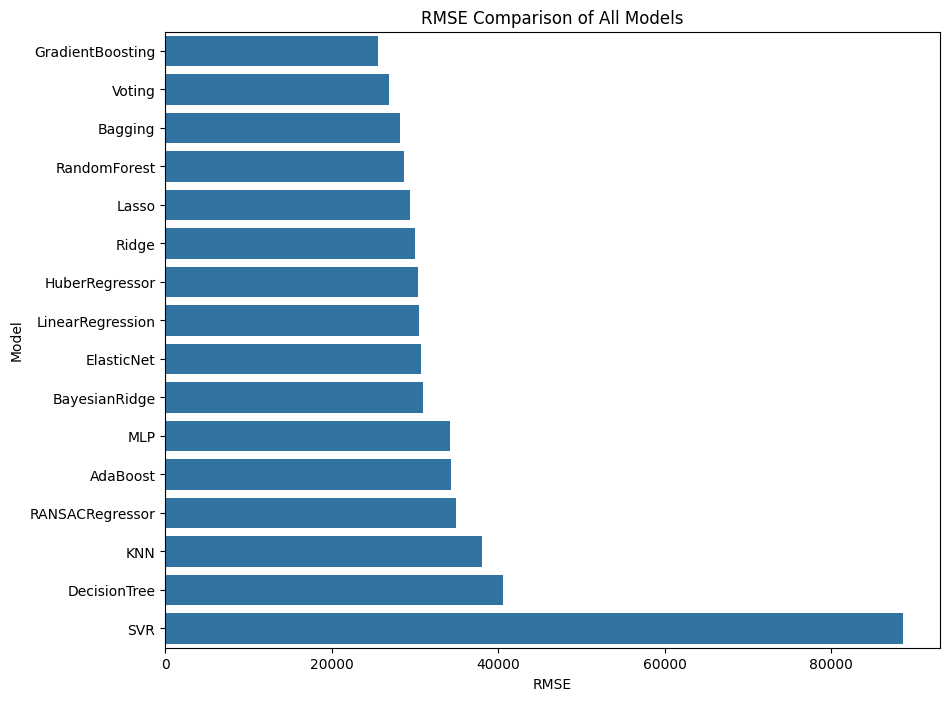

In [36]:
results_df = pd.DataFrame(results).sort_values(by="RMSE")
display(results_df)

plt.figure(figsize=(10,8))
sns.barplot(x="RMSE", y="Model", data=results_df)
plt.title("RMSE Comparison of All Models")
plt.show()